# Simulate place cell responses to a rat running through a box

In [ ]:
%matplotlib inline
from IPython import display
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import os

from anim import build_frames, create_gif, merge_frames
from aux import save_time_file
from ntwk import LIFNtwk
from sim import RandomTraj, InferredTraj
from sim import upstream_spikes_from_positions
import plot

# GENERAL PARAMS
SAVE_DIR = 'sims/place'
BOX = (-3, 3, -3, 3)
DUR = 15
DT = 0.0005

# TRAJ PARAMS

SEED = 0
SPEED = 1
SMOOTHNESS = 1

X_0 = (-2.5, -2.5)
V_0 = (.35, .35)

# NTWK PARAMS

N = 200
W_AMPA = 0.04
W_NMDA = 0.002
W_GABA = 0.01
SYNS = ['AMPA', 'NMDA', 'GABA']

NTWK_KWARGS = {
    't_m': 0.02,  # (s)
    'e_leak': -0.07,  # (V)
    'v_th': -0.036,  # (V)
    'v_reset': -0.07,  # (V)
    't_r': 0.002,  # (s)
    'es_rev': {'AMPA': 0, 'NMDA': 0, 'GABA': -0.08},  # (V)
    'ts_syn': {'AMPA': 0.001, 'NMDA': 0.02, 'GABA': 0.001},  # (s)
    'ws_rcr': {syn: np.zeros((N, N)) for syn in SYNS},  # (unitless)
    'ws_up': {
        'AMPA': W_AMPA * np.eye(N),
        'NMDA': np.zeros((N, N)),
        'GABA': np.zeros((N, N)),
    },
}

### Generate a random trajectory and upstream spike trains

In [ ]:
np.random.seed(SEED)

ts = np.arange(int(DUR/DT)) * DT

traj = RandomTraj(ts, SPEED, SMOOTHNESS, X_0, V_0, BOX)

centers = np.random.uniform(-3.5, 3.5, (2, N))

stds = 0.7 * np.ones(centers.shape[1])
max_rates = 1000 * np.ones(centers.shape[1])

spks_up = upstream_spikes_from_positions(ts, traj.xys, centers, stds, max_rates)

time_file = save_time_file(os.path.join(SAVE_DIR, 'time'), ts)
traj_file = traj.save(os.path.join(SAVE_DIR, 'traj'))

### Compute network response

In [ ]:
ntwk = LIFNtwk(**NTWK_KWARGS)
vs_init = NTWK_KWARGS['e_leak'] * np.ones(N)
gs_init = {syn: np.zeros(N) for syn in SYNS}
ntwk_response = ntwk.run(spks_up, vs_init, gs_init, DT)
ntwk_response.place_field_centers = centers

activity_file = ntwk_response.save(os.path.join(SAVE_DIR, 'ntwk'))

### Show trajectory and raster response

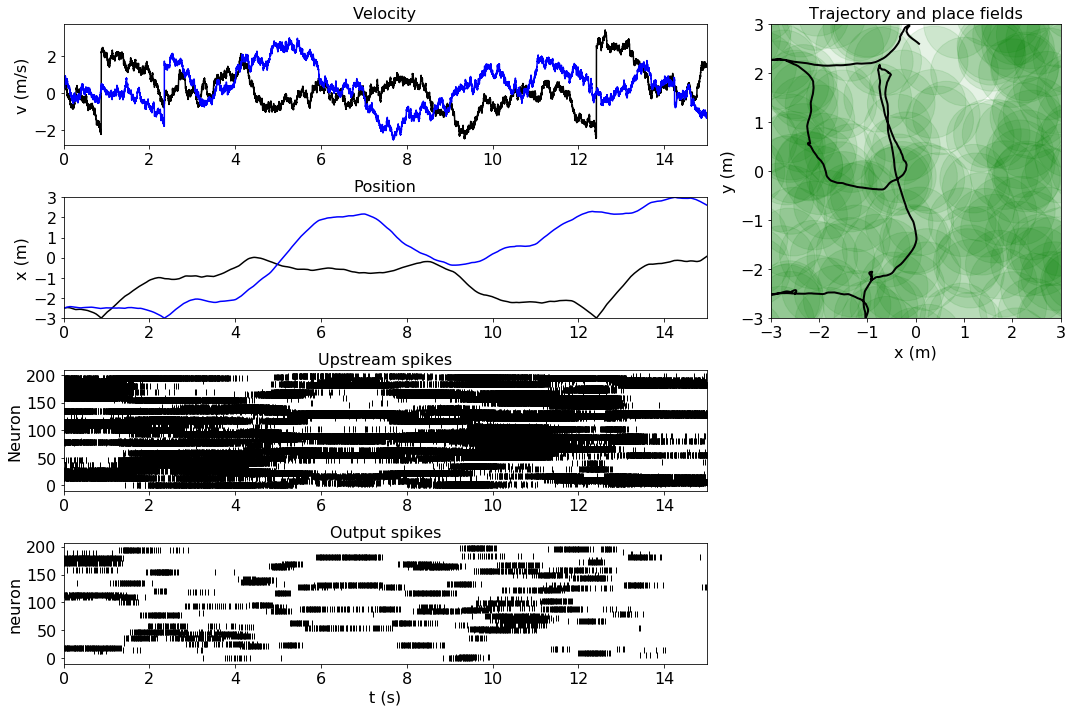

In [8]:
gs = gridspec.GridSpec(4, 3)
fig = plt.figure(figsize=(15, 10), tight_layout=True)

axs = [
    fig.add_subplot(gs[0, :2]),
    fig.add_subplot(gs[1, :2]),
    fig.add_subplot(gs[:2, 2]),
    fig.add_subplot(gs[2, :2]),
    fig.add_subplot(gs[3, :2]),
]

# velocity time-series
axs[0].plot(ts, traj.vs[:, 0], c='k')
axs[0].plot(ts, traj.vs[:, 1], c='b')
axs[0].set_xlim(ts[0], ts[-1])
axs[0].set_ylabel('v (m/s)')
axs[0].set_title('Velocity')

# position time-series
axs[1].plot(ts, traj.xys[:, 0], c='k')
axs[1].plot(ts, traj.xys[:, 1], c='b')
axs[1].set_xlim(ts[0], ts[-1])
axs[1].set_ylabel('x (m)')
axs[1].set_title('Position')

axs[1].set_ylim(-3, 3)

# trajectory
axs[2].plot(*traj.xys.T, color='k', lw=2)

# neuron place fields
for center, std in zip(centers.T, stds):
    ell = Ellipse(center, width=2*std, height=2*std, angle=0)
    axs[2].add_artist(ell)
    ell.set_alpha(0.1)
    ell.set_color('g')
    
axs[2].set_xlim(BOX[:2])
axs[2].set_ylim(BOX[2:])

axs[2].set_xlabel('x (m)')
axs[2].set_ylabel('y (m)')
axs[2].set_title('Trajectory and place fields')

# raster plot of place-sensitive cell responses
spk_times_up = spks_up.nonzero()[0] * DT

axs[3].scatter(spk_times_up, spks_up.nonzero()[1], marker='|', lw=1, c='k')
axs[3].set_xlim(ts[0], ts[-1])
axs[3].set_ylabel('Neuron')
axs[3].set_title('Upstream spikes')

plot.raster(
    axs[4],
    time_file,
    activity_file)

axs[4].set_xlim(ts[0], ts[-1])
axs[4].set_xlabel('t (s)')
axs[4].set_ylabel('neuron')
axs[4].set_title('Output spikes')

for ax in axs:
    plot.set_font_size(ax, 16)

### Calculate, plot, and save inferred trajectory

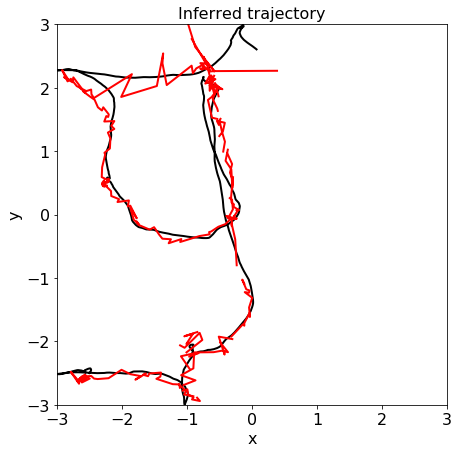

In [9]:
inferred = InferredTraj(
    ntwk_file=activity_file,
    time_file=time_file,
    window=0.05)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(*traj.xys.T, color='k', lw=2)
ax.plot(*inferred.xys.T, color='r', lw=2)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_title('Inferred trajectory')

plot.set_font_size(ax, 16)

inferred_file = inferred.save(os.path.join(SAVE_DIR, 'inferred'))

### Animate trajectory and neural response

In [ ]:
frames_traj = build_frames.traj(
    save_prefix=os.path.join(SAVE_DIR, 'traj/frame'),
    time_file=time_file,
    traj_file=traj_file,
    box=BOX,
    fps=60,
    title='Trajectory',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=(10, 10),
    verbose=True)

frames_ntwk = build_frames.ntwk_activity(
    save_prefix=os.path.join(SAVE_DIR, 'ntwk/frame'),
    time_file=time_file,
    activity_file=activity_file,
    box=BOX,
    fps=60,
    frames_per_spike=2,
    title='Network activity',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=(10, 10))

frames_inferred = build_frames.traj(
    save_prefix=os.path.join(SAVE_DIR, 'inferred/frame'),
    time_file=time_file,
    traj_file=inferred_file,
    box=BOX,
    fps=60,
    location_size=200,
    location_color=(0, 0, 1),
    cov_cutoff=np.inf,
    title='Inferred trajectory',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=(10, 10),
    verbose=True)

### Merge trajectory and network frames

In [ ]:
save_prefix = os.path.join(SAVE_DIR, 'merged/frame')
rects = [(0, 0, 1, 1), (1, 0, 2, 1), (0, 1, 1, 2)]
size = (2, 2)

frames_merged = merge_frames(
    [frames_traj, frames_ntwk, frames_inferred], save_prefix, rects, size)

### Make animated GIF of trajectory

In [ ]:
gif = create_gif(frames_merged, os.path.join(SAVE_DIR, 'full'), playback_fps=30, verbose=True)
display.HTML('<img src="{}" />'.format(gif))